In [1]:
import pandas as pd
import torch
from torch import nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

#删除ID,数据分类
x_train = train_data.iloc[:,1:-1]
y_train = train_data.iloc[:,-1:]
x_test = test_data.iloc[:,1:]
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)

# 使用 NumPy 来将 True 转换为 1，False 转换为 0
y_train = y_train.astype(int)

print(y_train.head(5))

(101763, 21)
(101763, 1)
(67842, 21)
   defects
0        0
1        0
2        0
3        1
4        0


In [2]:
#标准化数据时将每个数据点的偏差（差值）除以标准差的主要目的是将数据转化为标准正态分布（均值为0，标准差为1）
x_train = x_train.apply(lambda x:(x - x.mean())/(x.std()))

n_train = x_train.shape[0]

print(x_train.head(5))
print(y_train.head(5))

# 训练集特征和标签
x_train = torch.tensor(x_train.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32)

# 测试集特征
x_finally = torch.tensor(x_test.values, dtype=torch.float32)

        loc      v(g)     ev(g)     iv(g)         n         v         l  \
0 -0.281081 -0.315495 -0.398384 -0.270813 -0.214178 -0.204322 -0.515840   
1 -0.427601 -0.442064 -0.398384 -0.270813 -0.377780 -0.304543  0.283393   
2 -0.482545 -0.442064 -0.398384 -0.270813 -0.301822 -0.268046 -0.016319   
3 -0.537490 -0.568633 -0.398384 -0.451496 -0.430366 -0.349602  0.782914   
4 -0.482545 -0.442064 -0.398384 -0.270813 -0.465424 -0.375625  0.683010   

          d         i         e  ...         t    lOCode  lOComment   lOBlank  \
0  0.416259 -0.582892 -0.080835  ... -0.085031 -0.150553  -0.131124 -0.466891   
1 -0.473177 -0.282762 -0.104511  ... -0.110447 -0.306231  -0.300546 -0.466891   
2 -0.398822 -0.210573 -0.100223  ... -0.105843 -0.384070  -0.300546 -0.466891   
3 -0.597104 -0.424952 -0.106941  ... -0.113056 -0.487856  -0.300546 -0.310209   
4 -0.570194 -0.662081 -0.107508  ... -0.113664 -0.410017  -0.300546 -0.310209   

   locCodeAndComment   uniq_Op  uniq_Opnd  total_Op  total_Opn

In [3]:
# 划分数据集为训练集和测试集
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# 转换数据为PyTorch张量
x_train = torch.FloatTensor(x_train).to('cuda')
x_test = torch.FloatTensor(x_test).to('cuda')
y_train = torch.FloatTensor(y_train).to('cuda')
y_test = torch.FloatTensor(y_test).to('cuda')

In [4]:
print(torch.cuda.is_available())

True


In [7]:
# 定义逻辑回归模型并将其移到GPU
class LogisticRegression(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, 1).to('cuda')

    def forward(self, x):
        out = torch.sigmoid(self.linear(x))
        return out

# 初始化模型
input_dim = x_train.shape[1]
model = LogisticRegression(input_dim)

# 定义损失函数和优化器
criterion = nn.BCELoss()  # 二分类问题使用二元交叉熵损失
optimizer = optim.SGD(model.parameters(), lr=0.01)

# 训练模型
num_epochs = 20000
for epoch in range(num_epochs):
    # 前向传播
    outputs = model(x_train)
    loss = criterion(outputs, y_train.view(-1, 1))
    
    
    
    # 反向传播和优化
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch%10000 == 0:
        print('epochs',epoch//10000)
    

epochs 0
epochs 1
epochs 2
epochs 3
epochs 4
epochs 5
epochs 6
epochs 7
epochs 8
epochs 9


In [8]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

Accuracy: 0.811231759445782


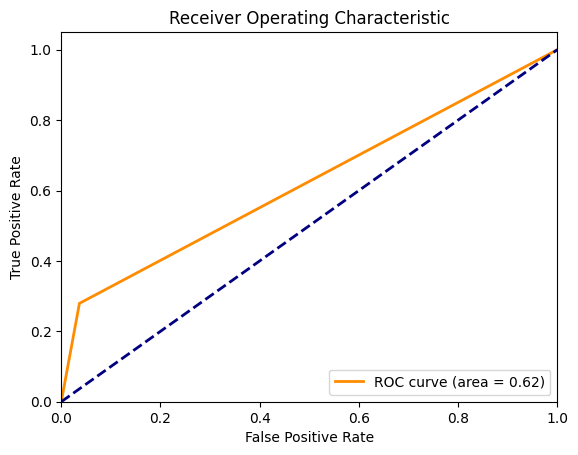

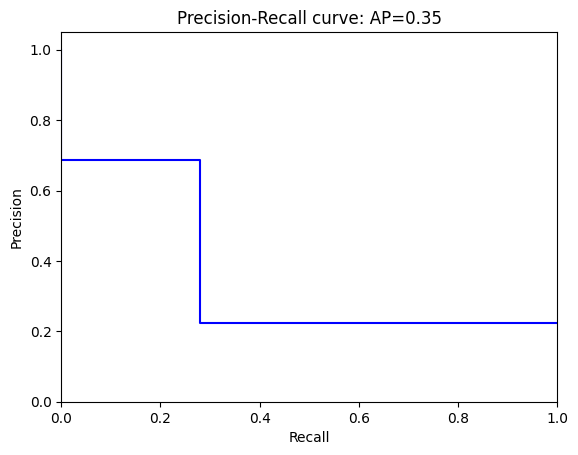

In [9]:
# 模型预测
model.eval()
with torch.no_grad():
    predicted = model(x_test)
    predicted = (predicted > 0.5).int().squeeze()

# 评估模型
accuracy = accuracy_score(y_test.cpu().numpy(), predicted.cpu().numpy())  # 将结果移到CPU并转换为NumPy数组
print(f'Accuracy: {accuracy}')

# 绘制ROC曲线
fpr, tpr, thresholds = roc_curve(y_test.cpu().numpy(), predicted.cpu().numpy())
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# 绘制PR曲线
precision, recall, _ = precision_recall_curve(y_test.cpu().numpy(), predicted.cpu().numpy())
average_precision = average_precision_score(y_test.cpu().numpy(), predicted.cpu().numpy())

plt.figure()
plt.step(recall, precision, color='b', where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(f'Precision-Recall curve: AP={average_precision:.2f}')
plt.show()

In [13]:
x_finally = x_finally.to('cuda')
preds = model(x_finally).detach()
preds = preds.to('cpu').numpy()

test_data['defects'] = pd.Series(preds.reshape(1,-1)[0])
submission = pd.concat([test_data['id'],test_data['defects']],axis=1)
submission.to_csv('submission.csv',index=False)

